#**오픈소스 팀 과제 - BERT를 활용한 대화 다중 분류 - 전유정**

허깅페이스(Hugging Face)에서 제공하는 transformer 라이브러리를 활용하여 한국어 BERT로 텍스트 대화 중에서 일반 텍스트, 성적 텍스트, 학교 폭력 텍스트를를 분류해보도록 하겠습니다.

1.1. 사용한 데이터
- 텍스트 윤리 검정 데이터
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=558

1.2. 데이터셋 구조
테스트 데이터, 44,998개 훈련 데이터 348,073개로 총 5개의 라벨로 이루어져 있습니다. 성적인 대화의 수가 적어 정확성이 높지 않은 경우를 고려하여, 성적인 데이터셋을 직접 수집하여 학습 데이터로 추가시켰습니다.

 - 일반 대화와 성적 대화, 학교 폭력 대화를 추출
 - 데이터 결측치 제거
 - Okt 라이브러리를 활용한 토큰화
다음과 같은 과정을 통해 데이터 전처리를 진행하였으며, 테스트 데이터 약 1만개, 훈련 데이터 약 8만개로 단축시켰으며, 간소화 하였으며, 라벨도 2개로 단축시켰습니다.

2. 모델 학습

 2.1. 훈련-테스트 데이터 분할
BERT 모델같이 사전 학습된 모델의 경우, 적은 데이터로도 좋은 성능을 낼 수 있습니다. 따라서, 테스트 데이터는 5만개를 전부 사용하였으며, 훈련 데이터의 경우 80%를 사용했습니다.

 2.2. BERT 토크나이저 불러오기

 2.3. DataLoader 구성

 2.4. BERT 모델 불러오기

 2.5. 모델 훈련



+ 초기에는 이진 판별로 모델을 학습 시키고자 했으나, 이진 판별만 하기에 데이터 셋의 크기가 컸기 때문에 성적 대화 뿐만 아니라 학교 폭력 대화까지 총 3가지의 대화를 클래스 별로 판별하고자 합니다.

1. VIOLENCE, CRIME, ABUSE 총 3가지의 데이터셋 라벨을 '학교 폭력 데이터'로 추출하였으며, 이를 각각 훈련과 테스트 데이터에 결합시켰습니다.

2. 하나의 모델에서 3개의 클래스를 학습 시키는 다중 클래스 분류 학습을 진행했었지만, 성능이 좋지 않았습니다. 따라서 첫 번째로 성적 대화인지 아닌지 판별하는 학습과 두 번째로 성적 대화를 제외한 데이터에서 학교 폭력 대화인지 아닌지 판별하는 학습 총 2회를 진행시켰습니다.

3. 2회 진행한 학습을 최종적으로 하나의 모델로 결합시켜, 총 3가지 클래스의 대화 판별이 가능하도록 했습니다.

-> train과 test 모두 loss는 우하향, accuracy와 f1-score는 우상향하는 모습이 보였으나, 성적 대화 판별을 하는 첫 번째 학습에서의 f1-score가 낮았습니다. 그 이유는 성적 대화와 일반, 학교 폭력 대화를 판별하는 과정에서, 성적 대화의 데이터 개수가 현저하게 적어 데이터 불균형이 있음을 확인할 수 있었습니다. 2차 수정에는 이러한 점을 보완할 예정입니다.

In [1]:
!pip install pandas
!pip install numpy
!pip install pillow
!pip install konlpy
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 40.3 MB/s eta 0:00:00


In [2]:


!pip install konlpy

In [3]:
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Hannanum
from PIL import Image
import numpy as np

# TEST 데이터

In [4]:
import pandas as pd

try:
    # 엑셀 파일 읽기
    df = pd.read_excel("test_data.xlsx", header=None)
    print("Successfully read the file.")

    # 첫 번째 행 제거
    df = df.iloc[1:].reset_index(drop=True)
    print("First row removed.")

    # 데이터프레임의 첫 몇 줄과 행 개수 출력
    print(df.head())
    num_rows = df.shape[0]
    print(f"Number of rows: {num_rows}")
except Exception as e:
    print(f"Failed to read the file. Error: {e}")

Successfully read the file.
First row removed.
   0      1    2  3              4                           5
0  1  False  0.0  1   IMMORAL_NONE    <마미손> 이번에 해명 영상 올렸던데 봤어?
1  2  False  0.0  2   IMMORAL_NONE        어 <염따> 제대로 큰일 난거 같던데
2  3   True  1.0  3  CENSURE,ABUSE  <염따> 뭐됐지 ㅋㅋ 그럴줄 알았다 티팔이 샛기
3  1  False  0.0  1   IMMORAL_NONE          요즘 같은 시대에 모솔이 가능해?
4  2  False  0.0  2   IMMORAL_NONE        흐음 글쎄.. 그럴 수도 있지, 뭐.
Number of rows: 57556


섹슈얼 데이터


In [5]:
import pandas as pd

# 'SEXUAL' 포함된 데이터프레임 추출
sexual_df = df[df[4].str.contains("SEXUAL")]

# 대화 유형과 텍스트 메세지만 추출
selected_sexual_df = sexual_df.iloc[:, [4, 5]]

# 데이터 행 개수 추출
num_rows = selected_sexual_df.shape[0]
print(f"SEXUAL 데이터 행 개수: {num_rows}")

SEXUAL 데이터 행 개수: 5490


일상 대화 데이터

In [6]:
import pandas as pd


# 'IMMORAL_NONE' 포함된 데이터프레임 추출
moral_df = df[df[4].str.contains("IMMORAL_NONE")]

# 대화 유형과 텍스트 메세지만 추출
moral_selected_df = moral_df.iloc[:, [4, 5]]

# 5천개 또는 가능한 최대 개수로 줄이기
sample_size = min(5500, len(moral_selected_df))
selected_moral_df = moral_selected_df.sample(n=sample_size, random_state=1)

# 결과 출력
print(selected_moral_df)


                  4                        5
815    IMMORAL_NONE                  그게 맞긴 해
9950   IMMORAL_NONE             정말 세금 아깝다...
7779   IMMORAL_NONE      그 사람 게임을 발로 하는거 맞지?
31647  IMMORAL_NONE                잘 놀다가 왔나?
29248  IMMORAL_NONE              도저히 납득이 안가네
...             ...                      ...
25699  IMMORAL_NONE    요즘 팝송 되게 좋지않아? 즐겨듣고있어
22430  IMMORAL_NONE          야 그정도 아닌데 오바하지마
35311  IMMORAL_NONE          <이름> 너무 예쁨ㅠㅠㅠㅠㅠ
19709  IMMORAL_NONE             계산기를 잘못 눌렀겠지
8206   IMMORAL_NONE  나 이번에 성적장학금 받았어 ㅎㅎㅎ 잘했지

[5500 rows x 2 columns]


학교 폭력 데이터


In [7]:
import pandas as pd


# 'VIOLENCE|CRIME|ABUSE' 포함된 데이터프레임 추출
violence_df = df[df[4].str.contains("VIOLENCE|CRIME|ABUSE")]

# 'SEXUAL'이 포함된 행을 제외
violence_df = violence_df[~violence_df[4].str.contains("SEXUAL", na=False)]

# 대화 유형과 텍스트 메세지만 추출
violence_selected_df = violence_df.iloc[:, [4, 5]]

# 5천개 또는 가능한 최대 개수로 줄이기
sample_size = min(5500, len(violence_selected_df))
violence_selected_df = violence_selected_df.sample(n=sample_size, random_state=1)

# 결과 출력
print(violence_selected_df)


                   4                                5
57312       VIOLENCE  원래 바퀴벌레는 생명령 ㅅㅌㅊ라 죽여도 죽여도 끝이 없음
56727          ABUSE                              앰뒤?
56559          ABUSE                             조옷까셈
51701          ABUSE     왜  봊  못 잡스런아먹어서 안달이니  갓나냔 들아
50989       VIOLENCE                   <이름> 강제로 하고 싶다
...              ...                              ...
24798       VIOLENCE               그럼 걍 나가서 한강물에 뛰어내려
29480  CENSURE,ABUSE     응 너는 개조져놔서 그것조차 안어울리는 것 같다^^
42824       VIOLENCE                  진짜 한 대 쎄게 치고 싶다
53633       VIOLENCE    제발 강의들을 떄 옆에서 말걸지마 죽빵 치고 싶으니까
54755          ABUSE                              엿먹어

[5500 rows x 2 columns]


섹슈얼 데이터 + 일상 대화 데이터 + 학교 폭력 데이터

In [8]:
test_merged_df = pd.concat([selected_sexual_df, selected_moral_df, violence_selected_df])

num_rows = test_merged_df.shape[0]
print(f"SEXUAL + IMMORAL_NONE + VIOLENCE 데이터 행 개수: {num_rows}")

SEXUAL + IMMORAL_NONE + VIOLENCE 데이터 행 개수: 16490


# Train 데이터

In [9]:
train_df = pd.read_csv("train1.xlsx", sep='\t', header=None)
train2_df = pd.read_csv("train2.xlsx", sep='\t', header=None)
train3_df = pd.read_csv("train3.xlsx", sep='\t', header=None)
train4_df = pd.read_csv("train4.xlsx", sep='\t', header=None)
# 두 데이터프레임 병합
merged_train_df = pd.concat([train_df, train2_df, train3_df, train4_df])
print(merged_train_df)

       0     1    2  3         4                                            5
0      1  True  2.0  1   CENSURE                  부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네
1      2  True  2.0  2   CENSURE                            맞아. 사람들이 진짜 개념이없다
2      3  True  2.0  1   CENSURE                                 저렇게는 살지 말아야지
3      4  True  2.0  2   CENSURE                       그러게 게으르고 멍청한 사람들은 맞아야해
4      1  True  1.0  1   CENSURE                            인방 보는 남자는 거르는게 맞다
...   ..   ...  ... ..       ...                                          ...
12660  3  True  2.4  1  VIOLENCE               그니까; 진짜 잡아서 날개 뜯고 머가리 뽑아버리고싶어.
12661  3  True  2.4  1     ABUSE               그니까; 진짜 잡아서 날개 뜯고 머가리 뽑아버리고싶어.
12662  2  True  1.8  1  VIOLENCE                         남자 아래에 깔려서 당하고 싶은건가?
12663  4  True  1.8  2    SEXUAL          저정도면 놀아달라는 거 아닌가? 저 라인봐봐 만지면 으스러지겠어
12664  5  True  2.6  1    SEXUAL  저 언덕 사이에 손을 넣고 주물러주면 그럴걸 ㅋㅋ 본인도 바라고 있지 않을까?

[515298 rows x 6 columns]


성적 대화 데이터

In [10]:
import pandas as pd

# 'SEXUAL' 포함된 데이터프레임 추출
train_sexual_df = merged_train_df[merged_train_df[4].str.contains("SEXUAL")]

# 대화 유형과 텍스트 메세지만 추출
train_selected_sexual_df = train_sexual_df.iloc[:, [4, 5]]

# 결과 출력
# 데이터 행 개수 추출
num_rows = train_selected_sexual_df.shape[0]
print(f"SEXUAL 데이터 행 개수: {num_rows}")

SEXUAL 데이터 행 개수: 40907


일반 대화 데이터

In [11]:
import pandas as pd

# 'IMMORAL_NONE' 포함된 데이터프레임 추출
train_moral_df =  merged_train_df[merged_train_df[4].str.contains("IMMORAL_NONE", na=False)]

# 대화 유형과 텍스트 메세지만 추출
train_selected_moral_df = train_moral_df.iloc[:, [4, 5]]

# 40100개 또는 가능한 최대 개수로 줄이기
sample_size = min(41000, len(train_selected_moral_df))
train_selected_moral_df = train_selected_moral_df.sample(n=sample_size, random_state=1)

# 결과 출력
print(train_selected_moral_df)

                   4                                5
70704   IMMORAL_NONE                    전생에 나라를 구한 듯.
22341   IMMORAL_NONE                 이 예쁜 유튜버 사진 좀 봐바
120712  IMMORAL_NONE                       <조권> 얘 뭐냐?
12628   IMMORAL_NONE               그러면 대부분 고등학생 정도 될듯
95124   IMMORAL_NONE               코로나 확진자는 계속해서 늘어나네
...              ...                              ...
107143  IMMORAL_NONE                   <미주> 너무 예쁘지 않냐
16069   IMMORAL_NONE            여기 애들은 같은 성별이면 용서되나보네
292454  IMMORAL_NONE         ㅋㅋㅋ 속도위반으로 임신해서 결혼하는 거잖아
115     IMMORAL_NONE                  어 그 덩치 좀 있는 애 ?
15524   IMMORAL_NONE  남자한테 사랑받고 연애하면 페미 그만두게 된다던 그 분?

[41000 rows x 2 columns]


학교 폭력 데이터

In [12]:
# 대화 유형이 "ABUSE", "VIOLENCE", "CRIME" 중 하나를 단독으로 포함하는 대화 추출
train_violence_df = merged_train_df[merged_train_df[4].str.contains("VIOLENCE|CRIME|ABUSE", na=False)]

# 대화 유형과 텍스트 메세지만 추출
train_selected_violence_df = train_violence_df.iloc[:, [4, 5]]

# 'SEXUAL'이 포함된 행을 제외
train_violence_df = train_violence_df[~train_violence_df[4].str.contains("SEXUAL", na=False)]

# 40100개 또는 가능한 최대 개수로 줄이기
sample_size = min(41000, len(train_selected_violence_df))
train_selected_violence_df = train_selected_violence_df .sample(n=sample_size, random_state=1)

print(train_selected_violence_df)

                    4                                           5
52560        VIOLENCE         아 진짜 이래서 위에것들이 입만 나불거리는데 진짜 패고 싶은거야
97395   CENSURE,ABUSE                 진짜 빡치니까 빨리 쳐 뛰어오라고 굼뱅이 색기야.
292374  CENSURE,ABUSE                  ㄹㅇ 거긴 볍신 전용 지하철 맞는 듯 줄라 웃겨
261064  CENSURE,ABUSE                  어휴 그걸 이제알았냐 너 십돼지련이라 살빼야했음
64900        VIOLENCE                                 진짜 쳐 죽이고 싶다
...               ...                                         ...
255114       VIOLENCE                      쪼개는 것만 봐도 뺨따귀 후려치고 싶더라
96539           ABUSE  배나온 한남충들 진짜 꼰떄이기까지하면 저 심연속에서 역겨움이 스멀스멀 올라옴
208641  CENSURE,ABUSE                      이댓글 추천하는 새히들은 최소한 개바보다
117885  CENSURE,ABUSE    이게 팩트야 이 멍청한 샛기야 ㅋㅋ 취업난인거 알면 이과로 전향해 뵹시나
81877           ABUSE         니 몸에 붙어 있는 지방들이 더 말 안 통할 것 같은데 돼지년아

[41000 rows x 2 columns]


In [13]:
train_merged_df = pd.concat([train_selected_sexual_df, train_selected_moral_df, train_selected_violence_df])
print(train_merged_df)

                          4                                           5
5       HATE,CENSURE,SEXUAL                      특히 벗방보는 애들은 진짜 거세 시켜야함
6            CENSURE,SEXUAL                          볼 게 없어서 벗방을 보냐 ㅋㅋㅋ
11           CENSURE,SEXUAL                        에로배우들을 데려다가 아이돌을 만드네
12           CENSURE,SEXUAL                           쟤네들은 표정이 딱 야동인데..
26             ABUSE,SEXUAL                              줫빠지게 힘들어서 잣같았다
...                     ...                                         ...
255114             VIOLENCE                      쪼개는 것만 봐도 뺨따귀 후려치고 싶더라
96539                 ABUSE  배나온 한남충들 진짜 꼰떄이기까지하면 저 심연속에서 역겨움이 스멀스멀 올라옴
208641        CENSURE,ABUSE                      이댓글 추천하는 새히들은 최소한 개바보다
117885        CENSURE,ABUSE    이게 팩트야 이 멍청한 샛기야 ㅋㅋ 취업난인거 알면 이과로 전향해 뵹시나
81877                 ABUSE         니 몸에 붙어 있는 지방들이 더 말 안 통할 것 같은데 돼지년아

[122907 rows x 2 columns]


In [14]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 895.8 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# 텍스트 데이터 토큰화

In [15]:
from konlpy.tag import Okt
import re
import pandas as pd

# 섹슈얼 데이터만 추출한 데이터프레임인 sexual_df가 이미 생성되어 있다고 가정합니다.
# 여기에 대해 전처리 작업을 수행하겠습니다.

# 형태소 분석기 초기화
tokenizer = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
    # 특수문자 및 반복적인 문자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    # "ㅋㅋ, ㅎㅎ"와 같은 특정한 문자열 패턴 제거
    text = re.sub(r'ㅋ+', '', text)
    text = re.sub(r'ㅎ+', '', text)
    text = re.sub(r'ㅠ+', '', text)
    text = re.sub(r'ㅡㅡ', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)  # 반복적인 문자 축약
    # 형태소 분석 및 불용어 처리
    morphs = tokenizer.morphs(text)
    stopwords = ['의','가','에','들','는','잘','걍','과','도','를','으로','한','하다', '히', '힣', '흠', '!','?','<','>','(',')','[',']','|','#','.']
    filtered_morphs = [word for word in morphs if not word in stopwords]
    return filtered_morphs

# 2번째 열 선택 (대화 텍스트)
text_column = test_merged_df.iloc[:, 1]

# 열을 문자열로 변환
text_column_str = text_column.astype(str)

# 텍스트 전처리 적용
preprocessed_text_column = text_column_str.apply(preprocess_text)

# 1번째 열 선택 (moral, sexual 라벨)
id_column = test_merged_df.iloc[:, 0]

# 1번째 열과 2번째 열 (라벨, 텍스트) 합쳐서 하나로 반환
result_df = pd.concat([id_column, preprocessed_text_column], axis=1)

# CSV로 저장
result_df.to_csv("result_df.csv", index=False, header=None)
print(result_df)

                         4                                             5
22     CENSURE,HATE,SEXUAL     [충격, 은, 니, ㅂㅈ, 속, 에서, 나올, 때, 니, 엄마, 받는거고]
32                  SEXUAL                           [어제, 얘, 따먹음, 물, 콸콸]
33            SEXUAL,CRIME                        [영상, 없음, 담, 엔, 찍어, 와라]
34            SEXUAL,CRIME                                 [오케, 무조건, 이지]
38                  SEXUAL  [ㅈ, 물, 처럼, 차, 버린, 뇌, 내, 망상, 배설, 하, 니까, 시원하다]
...                    ...                                           ...
24798             VIOLENCE                           [그럼, 나가서, 강물, 뛰어내려]
29480        CENSURE,ABUSE     [응, 너, 개조, 져, 놔서, 그것, 조차, 안, 어울리는, 것, 같다]
42824             VIOLENCE                           [진짜, 대, 쎄게, 치고, 싶다]
53633             VIOLENCE   [제발, 강의, 을, 떄, 옆, 에서, 말, 걸지마, 죽빵, 치고, 싶으니까]
54755                ABUSE                                         [엿먹어]

[16490 rows x 2 columns]


In [16]:
from konlpy.tag import Okt
import re
import pandas as pd

# 섹슈얼 데이터만 추출한 데이터프레임인 sexual_df가 이미 생성되어 있다고 가정합니다.
# 여기에 대해 전처리 작업을 수행하겠습니다.

# 형태소 분석기 초기화
tokenizer = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
    # 특수문자 및 반복적인 문자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    # "ㅋㅋ, ㅎㅎ"와 같은 특정한 문자열 패턴 제거
    text = re.sub(r'ㅋ+', '', text)
    text = re.sub(r'ㅎ+', '', text)
    text = re.sub(r'ㅠ+', '', text)
    text = re.sub(r'ㅡㅡ', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)  # 반복적인 문자 축약
    # 형태소 분석 및 불용어 처리
    morphs = tokenizer.morphs(text)
    stopwords = ['의','가','에','들','는','잘','걍','과','도','를','으로','한','하다', '히', '힣', '흠', '!','?','<','>','(',')','[',']','|','#','.']
    filtered_morphs = [word for word in morphs if not word in stopwords]
    return filtered_morphs

# 2번째 열 선택 (대화 텍스트)
t_text_column = train_merged_df.iloc[:, 1]

# 열을 문자열로 변환
t_text_column_str = t_text_column.astype(str)

# 텍스트 전처리 적용
t_preprocessed_text_column = t_text_column_str.apply(preprocess_text)

# 1번째 열 선택 (moral, sexual 라벨)
t_id_column = train_merged_df.iloc[:, 0]

# 1번째 열과 2번째 열 (라벨, 텍스트) 합쳐서 하나로 반환
t_result_df = pd.concat([t_id_column, t_preprocessed_text_column], axis=1)

# CSV로 저장
t_result_df.to_csv("t_result_df.csv", index=False, header=None)
print(t_result_df)

                          4                                                  5
5       HATE,CENSURE,SEXUAL                 [특히, 벗방, 보는, 애, 은, 진짜, 거세, 시켜, 야함]
6            CENSURE,SEXUAL                             [볼, 게, 없어서, 벗방, 을, 보냐]
11           CENSURE,SEXUAL                   [에로, 배우, 을, 데려다가, 아이돌, 을, 만드, 네]
12           CENSURE,SEXUAL                       [쟤, 네, 들은, 표정, 이, 딱, 야동, 인데]
26             ABUSE,SEXUAL                             [줫빠지, 게, 힘들어서, 잣, 같았다]
...                     ...                                                ...
255114             VIOLENCE                  [쪼개는, 것, 만, 봐도, 뺨따귀, 후려, 치고, 싶더라]
96539                 ABUSE  [배, 나온, 남충, 진짜, 꼰떄, 이기, 까지, 하면, 저, 심, 연속, 에서, ...
208641        CENSURE,ABUSE             [이, 댓글, 추천, 하는, 새히, 들은, 최소한, 개, 바보, 다]
117885        CENSURE,ABUSE  [이, 게, 팩트, 야, 이, 멍청한, 샛기, 야, 취업, 난, 인거, 알, 면, ...
81877                 ABUSE  [니, 몸, 붙어, 있는, 지방, 이, 더, 말, 안, 통, 할, 것, 같은데, 돼...

[122907 rows x 2 columns]


# 모델 학습

다중 분류를 시도한 첫 시도에는
IMMORAL_NONE(일반 문장)은 0, SEXUAL(성적 문장) 은 1, VIOLENCE(폭력 문장)은 2로 하나의 모델 학습으로 3개의 클래스를 분류하는 다중 분류 학습을 진행했습니다. 하지만 그렇게 하니 정확도, F1 Score 모두 좋지 않은 성능을 보였습니다.

그래서 stage1, stage2로 나눠 모델 학습을 다중 분류로 진행하지 않고, 이진 분류로 2번 진행하도록 했습니다. stage1(첫 학습)에서는 SEXUAL과 UNSEXUAL(일반적 문장, 학교 폭력 문장)문장만 구분하도록, stage2(두 번째 학습)에서는 IMMORAL_NONE(일반적 문장)과 VIOLENCE(폭력적 문장)을 구분하도록 했습니다.

모델 학습 시간은 에폭 5씩 2번 실행을 시킴으로써 더 오래 걸렸지만, 성능은 더 개선된 결과를 볼 수 있었습니다.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   0%|          | 0/2305 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value o

Epoch 1/5 (Stage 1)
Train Loss: 0.4625, Train Accuracy: 0.7891
Test Loss: 0.4081, Test Accuracy: 0.8157
F1 Score: 0.5679


Epoch 2/5 (Stage 1)
Train Loss: 0.4105, Train Accuracy: 0.8071
Test Loss: 0.3831, Test Accuracy: 0.8220
F1 Score: 0.6293


Epoch 3/5 (Stage 1)
Train Loss: 0.3895, Train Accuracy: 0.8156
Test Loss: 0.3839, Test Accuracy: 0.8297
F1 Score: 0.6461


Epoch 4/5 (Stage 1)
Train Loss: 0.3771, Train Accuracy: 0.8216
Test Loss: 0.3814, Test Accuracy: 0.8323
F1 Score: 0.6328


Epoch 5/5 (Stage 1)
Train Loss: 0.3685, Train Accuracy: 0.8239
Test Loss: 0.3787, Test Accuracy: 0.8313
F1 Score: 0.6432


Training:   0%|          | 0/1783 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/5 (Stage 2)
Train Loss: 0.4533, Train Accuracy: 0.7866
Test Loss: 0.3449, Test Accuracy: 0.8629
F1 Score: 0.8741


Epoch 2/5 (Stage 2)
Train Loss: 0.3660, Train Accuracy: 0.8402
Test Loss: 0.3125, Test Accuracy: 0.8756
F1 Score: 0.8879


Epoch 3/5 (Stage 2)
Train Loss: 0.3366, Train Accuracy: 0.8556
Test Loss: 0.3153, Test Accuracy: 0.8810
F1 Score: 0.8927


Epoch 4/5 (Stage 2)
Train Loss: 0.3141, Train Accuracy: 0.8654
Test Loss: 0.3144, Test Accuracy: 0.8795
F1 Score: 0.8893


Epoch 5/5 (Stage 2)
Train Loss: 0.3020, Train Accuracy: 0.8716
Test Loss: 0.3182, Test Accuracy: 0.8796
F1 Score: 0.8886
Final models saved to final_stage1_model.pth and final_stage2_model.pth


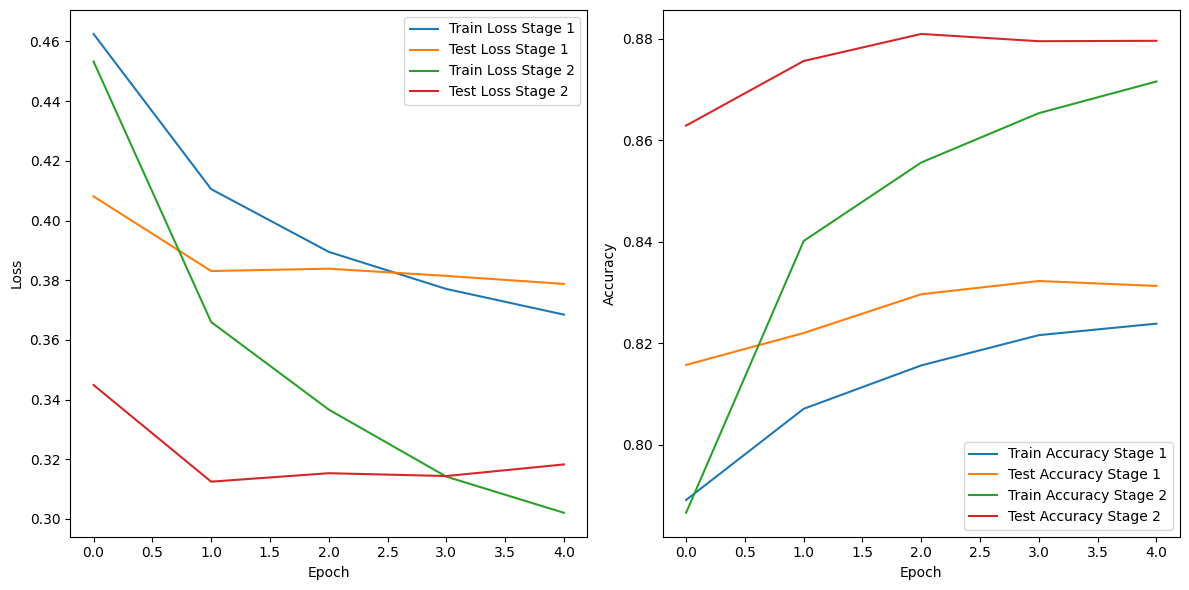

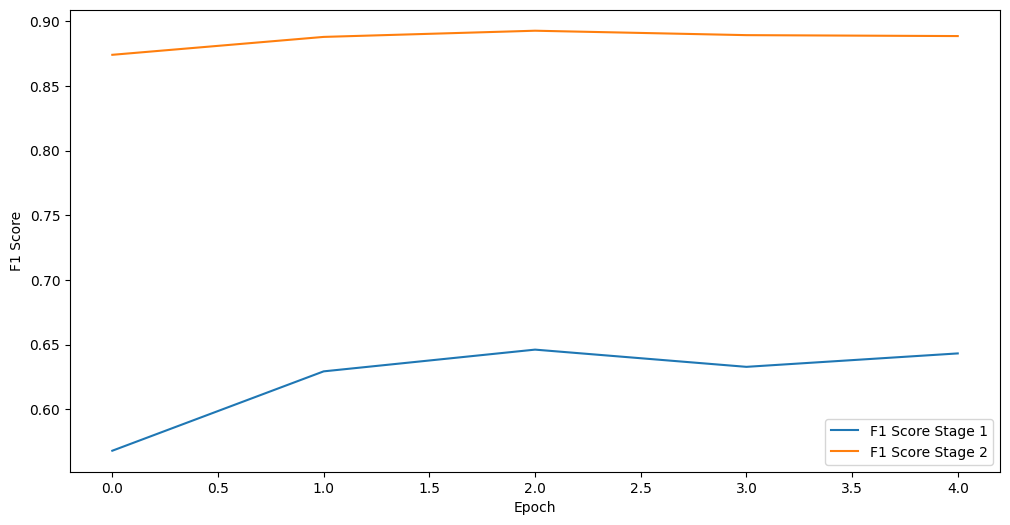

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.cuda.amp import GradScaler, autocast

# 데이터 로드 및 전처리
def label_mapping_stage1(label):
    if label == 'SEXUAL':
        return 1
    else:
        return 0

def label_mapping_stage2(label):
    if label == 'IMMORAL_NONE':
        return 0
    else:
        return 1

train_data = pd.read_csv("t_result_df.csv", header=None, names=['label', 'text'])
train_data['label_stage1'] = train_data['label'].apply(label_mapping_stage1)
train_data['label_stage2'] = train_data['label'].apply(label_mapping_stage2)

test_data = pd.read_csv("result_df.csv", header=None, names=['label', 'text'])
test_data['label_stage1'] = test_data['label'].apply(label_mapping_stage1)
test_data['label_stage2'] = test_data['label'].apply(label_mapping_stage2)

# 트레인 데이터의 60%만 사용
train_data, _ = train_test_split(train_data, train_size=0.6, random_state=42, stratify=train_data['label_stage1'])

# BERT용 데이터셋 정의
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 데이터셋 및 데이터로더 생성
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
max_length = 128

# Stage 1 데이터셋
train_dataset_stage1 = BertDataset(train_data['text'].values, train_data['label_stage1'].values, tokenizer, max_length)
test_dataset_stage1 = BertDataset(test_data['text'].values, test_data['label_stage1'].values, tokenizer, max_length)

train_loader_stage1 = DataLoader(train_dataset_stage1, batch_size=32, shuffle=True, num_workers=2)
test_loader_stage1 = DataLoader(test_dataset_stage1, batch_size=32, shuffle=False, num_workers=2)

# Stage 2 데이터셋
non_sexual_train_data = train_data[train_data['label_stage1'] == 0]
non_sexual_test_data = test_data[test_data['label_stage1'] == 0]

train_dataset_stage2 = BertDataset(non_sexual_train_data['text'].values, non_sexual_train_data['label_stage2'].values, tokenizer, max_length)
test_dataset_stage2 = BertDataset(non_sexual_test_data['text'].values, non_sexual_test_data['label_stage2'].values, tokenizer, max_length)

train_loader_stage2 = DataLoader(train_dataset_stage2, batch_size=32, shuffle=True, num_workers=2)
test_loader_stage2 = DataLoader(test_dataset_stage2, batch_size=32, shuffle=False, num_workers=2)

# BERT 모델 로드
model_stage1 = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=2,  # 이진 분류
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.3
)

model_stage2 = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=2,  # 이진 분류
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.3
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stage1.to(device)
model_stage2.to(device)

optimizer_stage1 = optim.AdamW(model_stage1.parameters(), lr=1e-5)
optimizer_stage2 = optim.AdamW(model_stage2.parameters(), lr=1e-5)

criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

# 학습률 스케줄러 설정
total_steps_stage1 = len(train_loader_stage1) * 5  # num_epochs를 5로 가정
scheduler_stage1 = get_linear_schedule_with_warmup(optimizer_stage1, num_warmup_steps=0, num_training_steps=total_steps_stage1)

total_steps_stage2 = len(train_loader_stage2) * 5  # num_epochs를 5로 가정
scheduler_stage2 = get_linear_schedule_with_warmup(optimizer_stage2, num_warmup_steps=0, num_training_steps=total_steps_stage2)

# 학습 및 평가 함수 정의
def train_epoch(model, data_loader, optimizer, criterion, device, scaler, scheduler):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()
        total_predictions += len(labels)
        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item(), accuracy=correct_predictions / total_predictions)

    accuracy = correct_predictions / total_predictions
    return epoch_loss / len(data_loader), accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            epoch_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += len(labels)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item(), accuracy=correct_predictions / total_predictions)

    accuracy = correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_predictions, average='binary')
    return epoch_loss / len(data_loader), accuracy, f1

# Stage 1 Training and Evaluation
num_epochs = 5

train_losses_stage1 = []
test_losses_stage1 = []
train_accuracies_stage1 = []
test_accuracies_stage1 = []
f1_scores_stage1 = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model_stage1, train_loader_stage1, optimizer_stage1, criterion, device, scaler, scheduler_stage1)
    test_loss, test_accuracy, f1 = evaluate(model_stage1, test_loader_stage1, criterion, device)

    train_losses_stage1.append(train_loss)
    train_accuracies_stage1.append(train_accuracy)
    test_losses_stage1.append(test_loss)
    test_accuracies_stage1.append(test_accuracy)
    f1_scores_stage1.append(f1)

    tqdm.write(f'Epoch {epoch + 1}/{num_epochs} (Stage 1)')
    tqdm.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    tqdm.write(f'F1 Score: {f1:.4f}')

    # Stage 1 모델 저장
    torch.save(model_stage1.state_dict(), "stage1_model.pth")

# Stage 2 Training and Evaluation
train_losses_stage2 = []
test_losses_stage2 = []
train_accuracies_stage2 = []
test_accuracies_stage2 = []
f1_scores_stage2 = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model_stage2, train_loader_stage2, optimizer_stage2, criterion, device, scaler, scheduler_stage2)
    test_loss, test_accuracy, f1 = evaluate(model_stage2, test_loader_stage2, criterion, device)

    train_losses_stage2.append(train_loss)
    train_accuracies_stage2.append(train_accuracy)
    test_losses_stage2.append(test_loss)
    test_accuracies_stage2.append(test_accuracy)
    f1_scores_stage2.append(f1)

    tqdm.write(f'Epoch {epoch + 1}/{num_epochs} (Stage 2)')
    tqdm.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    tqdm.write(f'F1 Score: {f1:.4f}')

    # Stage 2 모델 저장
    torch.save(model_stage2.state_dict(), "stage2_model.pth")

# 최종 모델 저장
torch.save(model_stage1.state_dict(), "final_stage1_model.pth")
torch.save(model_stage2.state_dict(), "final_stage2_model.pth")
print("Final models saved to final_stage1_model.pth and final_stage2_model.pth")

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_stage1, label='Train Loss Stage 1')
plt.plot(test_losses_stage1, label='Test Loss Stage 1')
plt.plot(train_losses_stage2, label='Train Loss Stage 2')
plt.plot(test_losses_stage2, label='Test Loss Stage 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_stage1, label='Train Accuracy Stage 1')
plt.plot(test_accuracies_stage1, label='Test Accuracy Stage 1')
plt.plot(train_accuracies_stage2, label='Train Accuracy Stage 2')
plt.plot(test_accuracies_stage2, label='Test Accuracy Stage 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# F1 스코어 시각화
plt.figure(figsize=(12, 6))
plt.plot(f1_scores_stage1, label='F1 Score Stage 1')
plt.plot(f1_scores_stage2, label='F1 Score Stage 2')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


모델 학습 결과

Stage 1 -> 성적 문장인지 아닌지 판별하는 모델 학습

Train Loss: 0.3685, Train Accuracy: 0.8239

Test Loss: 0.3787, Test Accuracy: 0.8313

F1 Score: 0.6432

Stage 2 -> 일반 문장인지 학교 폭력 문장인지 판별하는 모델 학습

Train Loss: 0.3020, Train Accuracy: 0.8716

Test Loss: 0.3182, Test Accuracy: 0.8796

F1 Score: 0.8886

다음과 같은 결과가 나왔고, 그래프 역시 loss는 우하향, accuracy는 우상향, f1-score는 우상향하는 모습을 살펴볼 수 있음

In [19]:
import torch.nn as nn
from transformers import BertModel

class MultiTaskBertModel(nn.Module):
    def __init__(self, model_name, num_labels_stage1, num_labels_stage2):
        super(MultiTaskBertModel, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier_stage1 = nn.Linear(self.bert.config.hidden_size, num_labels_stage1)
        self.classifier_stage2 = nn.Linear(self.bert.config.hidden_size, num_labels_stage2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs[1])
        logits_stage1 = self.classifier_stage1(pooled_output)
        logits_stage2 = self.classifier_stage2(pooled_output)
        return logits_stage1, logits_stage2

# 모델 초기화
model = MultiTaskBertModel('bert-base-multilingual-cased', num_labels_stage1=2, num_labels_stage2=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MultiTaskBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [20]:
import torch

# 모델 저장 함수 정의
def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# 최종 모델 저장
save_model(model, "final_multitask_model.pth")


Model saved to final_multitask_model.pth


# 모델 성능 지표 확인

In [61]:
import torch
from sklearn.metrics import classification_report
from transformers import BertTokenizer

# 모델 평가 및 성능 지표 출력 함수 정의
def evaluate_and_report(final_model, test_loader_stage1, test_loader_stage2, device):
    final_model.eval()

    all_predictions_stage1 = []
    all_labels_stage1 = []
    all_predictions_stage2 = []
    all_labels_stage2 = []

    with torch.no_grad():
        # Stage 1 예측
        for batch in test_loader_stage1:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = final_model(input_ids, attention_mask=attention_mask, stage=1)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions_stage1.extend(predictions.cpu().numpy())
            all_labels_stage1.extend(labels.cpu().numpy())

        # Stage 2 예측 (Non-sexual 데이터)
        for batch in test_loader_stage2:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = final_model(input_ids, attention_mask=attention_mask, stage=2)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions_stage2.extend(predictions.cpu().numpy())
            all_labels_stage2.extend(labels.cpu().numpy())

    # Stage 1 성능 지표 출력
    print("Stage 1 Classification Report (SEXUAL (성적 문장) vs NON-SEXUAL (일반적 문장, 학교 폭력 문장)):")
    print(classification_report(all_labels_stage1, all_predictions_stage1, target_names=['NON-SEXUAL', 'SEXUAL']))

    # Stage 2 성능 지표 출력
    print("Stage 2 Classification Report (IMMORAL_NONE (일반적 문장) vs VIOLENCE (학교 폭력 문장)):")
    print(classification_report(all_labels_stage2, all_predictions_stage2, target_names=['IMMORAL_NONE', 'VIOLENCE']))

# 최종 모델 클래스 정의
class FinalModel(nn.Module):
    def __init__(self, model_stage1, model_stage2):
        super(FinalModel, self).__init__()
        self.model_stage1 = model_stage1
        self.model_stage2 = model_stage2

    def forward(self, input_ids, attention_mask, stage):
        if stage == 1:
            return self.model_stage1(input_ids, attention_mask=attention_mask).logits
        else:
            return self.model_stage2(input_ids, attention_mask=attention_mask).logits

# 최종 모델 인스턴스 생성 및 평가
final_model = FinalModel(model_stage1, model_stage2).to(device)
evaluate_and_report(final_model, test_loader_stage1, test_loader_stage2, device)


Stage 1 Classification Report (SEXUAL (성적 문장) vs NON-SEXUAL (일반적 문장, 학교 폭력 문장)):
              precision    recall  f1-score   support

  NON-SEXUAL       0.89      0.89      0.89     12561
      SEXUAL       0.65      0.64      0.64      3929

    accuracy                           0.83     16490
   macro avg       0.77      0.76      0.77     16490
weighted avg       0.83      0.83      0.83     16490

Stage 2 Classification Report (IMMORAL_NONE (일반적 문장) vs VIOLENCE (학교 폭력 문장)):
              precision    recall  f1-score   support

IMMORAL_NONE       0.83      0.91      0.87      5500
    VIOLENCE       0.93      0.85      0.89      7061

    accuracy                           0.88     12561
   macro avg       0.88      0.88      0.88     12561
weighted avg       0.88      0.88      0.88     12561



SEXUAL의 성능이 낮은 이유는 support 즉 테스트 문장이 3929개로, 일반적 문장 + 학교 폭력 문장을 합친 문장보다 부족했기 때문에 생긴 현상이라고 유추됩니다.

다음 학습엔 SEXUAL의 테스트 문장을 1000개 증가시킬 예정입니다.

# 예측

In [62]:
import torch
from transformers import BertTokenizer
import numpy as np

# 예측 함수 정의
def predict_class(sentence, model_stage1, model_stage2, tokenizer, max_length, device):
    model_stage1.eval()
    model_stage2.eval()

    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Stage 1 예측 (SEXUAL 여부)
    with torch.no_grad():
        outputs_stage1 = model_stage1(input_ids, attention_mask=attention_mask)
        probabilities_stage1 = torch.nn.functional.softmax(outputs_stage1.logits, dim=-1)
        predicted_class_stage1 = torch.argmax(probabilities_stage1, dim=1).item()

    if predicted_class_stage1 == 1:
        return "SEXUAL", probabilities_stage1.cpu().numpy()

    # Stage 2 예측 (Non-sexual 데이터)
    with torch.no_grad():
        outputs_stage2 = model_stage2(input_ids, attention_mask=attention_mask)
        probabilities_stage2 = torch.nn.functional.softmax(outputs_stage2.logits, dim=-1)
        predicted_class_stage2 = torch.argmax(probabilities_stage2, dim=1).item()

    if predicted_class_stage2 == 0:
        return "IMMORAL_NONE", probabilities_stage2.cpu().numpy()
    else:
        return "SCHOOL VIOLENCE", probabilities_stage2.cpu().numpy()

# 토크나이저 및 디바이스 설정
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 예측할 문장
test_sentence = "몰카 영상 보니까 짜릿하다"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")


입력 문장: 몰카 영상 보니까 짜릿하다
예측된 클래스: SEXUAL
클래스 확률: [[0.30867895 0.6913211 ]]


In [63]:
# 예측할 문장
test_sentence = "오픈 소스 수업 가야지?"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 오픈 소스 수업 가야지?
예측된 클래스: IMMORAL_NONE
클래스 확률: [[0.99581224 0.00418771]]


In [64]:
# 예측할 문장
test_sentence = "섹시한 영상 있으면 돈 줄게"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 섹시한 영상 있으면 돈 줄게
예측된 클래스: SEXUAL
클래스 확률: [[0.17174637 0.8282536 ]]


In [65]:
# 예측할 문장
test_sentence = "너 담배 안 사오면 죽인다"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 너 담배 안 사오면 죽인다
예측된 클래스: SCHOOL VIOLENCE
클래스 확률: [[0.1238414 0.8761586]]


In [66]:
# 예측할 문장
test_sentence = "같은 반 여자애 몸매 쩔더라"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 같은 반 여자애 몸매 쩔더라
예측된 클래스: SEXUAL
클래스 확률: [[0.17041191 0.82958806]]


In [67]:
# 예측할 문장
test_sentence = "와, 너 한 대 치고 싶게 생겼음"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 와, 너 한 대 치고 싶게 생겼음
예측된 클래스: SCHOOL VIOLENCE
클래스 확률: [[0.08866611 0.9113339 ]]


In [68]:
# 예측할 문장
test_sentence = "골때리게 하면 빠다 때린다"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 골때리게 하면 빠다 때린다
예측된 클래스: SCHOOL VIOLENCE
클래스 확률: [[0.00710558 0.9928945 ]]


In [69]:
# 예측할 문장
test_sentence = "말을 왜이렇게 나쁘게 해"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 말을 왜이렇게 나쁘게 해
예측된 클래스: IMMORAL_NONE
클래스 확률: [[0.9969279  0.00307214]]


In [70]:
# 예측할 문장
test_sentence = "내 여자친구 엄청 귀여워!"

# 예측
predicted_class, probabilities = predict_class(test_sentence, model_stage1, model_stage2, tokenizer, max_length=128, device=device)

print(f"입력 문장: {test_sentence}")
print(f"예측된 클래스: {predicted_class}")
print(f"클래스 확률: {probabilities}")

입력 문장: 내 여자친구 엄청 귀여워!
예측된 클래스: IMMORAL_NONE
클래스 확률: [[0.996356 0.003644]]
